# Calculating Distance From Acc
1. Android-linear acceleration
2. Low pass filter on raw acceleration 
3. LPF for calculating Linear acceleration

References to go through:
* https://blog.prosig.com/2003/04/28/data-smoothing-rc-filtering-and-exponential-averaging/
* https://stackoverflow.com/questions/12926459/calculating-distance-using-linear-acceleration-android?rq=1


In [1]:
from scipy import fftpack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2. Filtering raw acceleration with LPF
* alpha: 
    * alpha is calculated as t / (t + dT) : android
    * alpha is calculated as dt / (t + dT) : wikipedia
    * close to 1 is no latency in output for android

* Time Constant (T): relative length of the signal that the low pass filter will act on
* dt: sample frequency
* As alpha becomes smaller, the time constant becomes larger and the filter performs more smoothing on the signal

### Static Android alpha LPF

In [50]:
df = pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv'
                    ,sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df = df[400:(400*8)] # taking, data from 2-10 sec

In [44]:
def low_pass_filter(data, alpha):
    # calculate the time constant
    # tau = 1/(2*np.pi*cutoff_freq)
    # calculate the alpha
    # alpha = sample_freq*tau/(sample_freq*tau + 1)
    
    # initialize the filtered data array
    filtered_data = [data.iloc[0]]
    for i in range(1, len(data)):
        #acc*a + 1-a * g
        filtered_data.append(alpha*data.iloc[i] + (1-alpha)*filtered_data[i-1])
    print(alpha, np.mean(filtered_data))
    return filtered_data

Text(0, 0.5, 'measured acc in z')

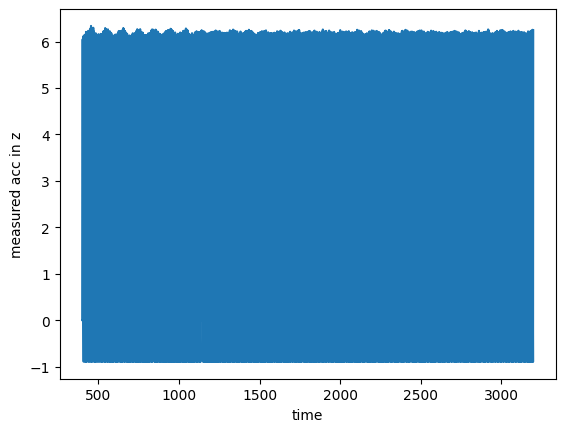

In [45]:
plt.plot(df['z'],label='original')
plt.xlabel('time')
plt.ylabel('measured acc in z')

0.001 1.0888068983021575
0.01 1.5802168759495394


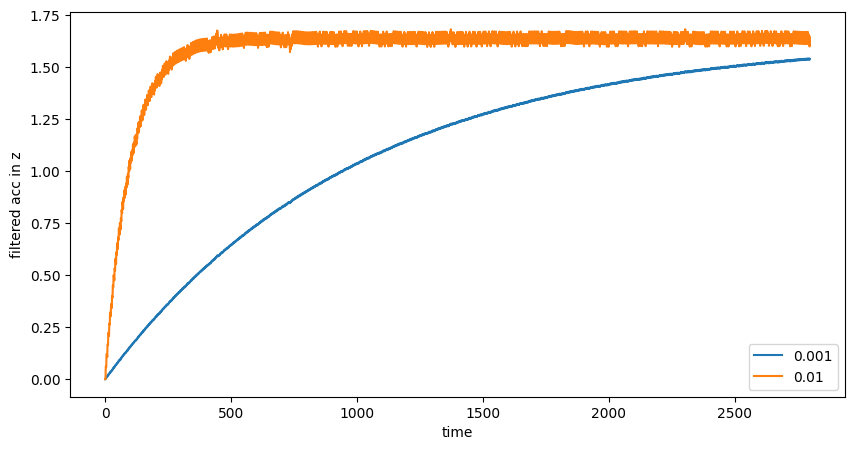

In [46]:
plt.figure(figsize=(10,5))
plt.plot(low_pass_filter(df['z'],0.001),label='0.001')
plt.plot(low_pass_filter(df['z'],0.01),label='0.01')
plt.xlabel('time')
plt.ylabel('filtered acc in z')
plt.legend()

Anything longer than T sec get passed through filter.
* with alpha=0.01, dt=0.04, T is 3.96. 
* with alpha=0.001, dt=0.04, T is 39.96

0.3 1.6365459927487644
0.2 1.6356424526352982


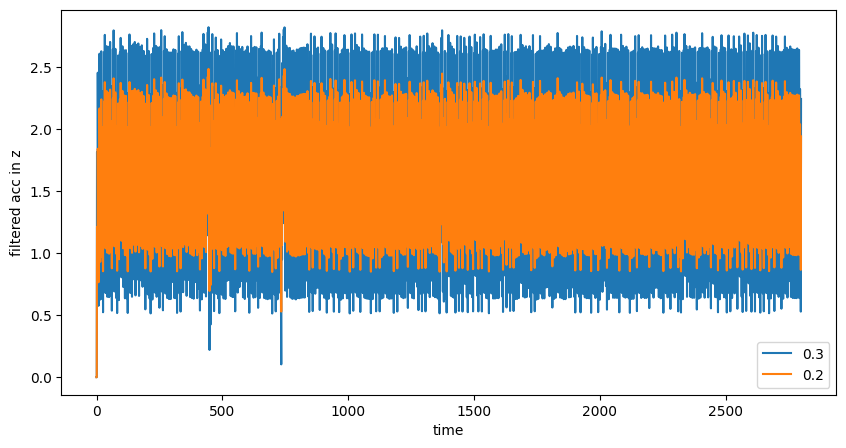

In [47]:
plt.figure(figsize=(10,5))
plt.plot(low_pass_filter(df['z'],0.3),label='0.3')
plt.plot(low_pass_filter(df['z'],0.2),label='0.2')
plt.xlabel('time')
plt.ylabel('filtered acc in z')
plt.legend()

In [48]:
df['acc_x'] = low_pass_filter(df['x'],0.01)
df['acc_y'] = low_pass_filter(df['y'],0.01)
df['acc_z'] = low_pass_filter(df['z'],0.01)
df['acc'] = np.sqrt(df['acc_x']*df['acc_x'] + df['acc_y']*df['acc_y'] + df['acc_z']*df['acc_z'])


0.01 0.032987073877861706
0.01 1.9665579050211142
0.01 1.5802168759495394


In [49]:
dist = 0.0 # meters
ini_vel = 0.0

for i in range(1,len(df)):
    interval  = (df.iloc[i]['time'] - df.iloc[i-1]['time']) / 1e+9
    fin_vel  = ini_vel + (df.iloc[i]['acc']*interval) #u+at
    dist += (ini_vel*interval) + 0.5*df.iloc[i]['acc']*interval*interval #ut+0.5*at^2
    ini_vel= fin_vel
print(dist,ini_vel)

5.028422824021857 5.177492361388729


### For treated data

In [56]:
df2 = pd.DataFrame({'time':[],'x':[],'y':[],'z':[]})
n = df['time'].iloc[0]


while (n < df['time'].iloc[-1]):
    recs = df[(df['time'] >=n) & (df['time']<n+ 1e+9)].copy()
    x = list(np.diff(np.diff(recs['time'])))
    x.insert(0,0)
    x.insert(0,0)
    recs['time_diff'] = x 
    desc = recs[recs['time_diff']==0].describe().T[['mean','min','50%']].T 
    # df2.iloc[counter:counter + len(recs)] = recs
    df2 = pd.concat([df2,recs],axis=0)
    if len(recs) < 400:
        t = 400-len(recs)
        # filling the missing data with smallest deltaT within the sec
        recs = pd.DataFrame({'time':np.arange(df2['time'].iloc[-1]+1,df2['time'].iloc[-1]+t+1),'x':[desc['x']['min']]*t,'y':[desc['y']['min']]*t,'z':[desc['z']['min']]*t}) # 
        # df2.iloc[counter + len(recs):counter + len(recs) + (400-len(recs))] = 0
        df2 = pd.concat([df2,recs],axis=0)
    n= n+1e+9
print(df2.shape)

(3188, 9)


Text(0, 0.5, 'measured acc in z')

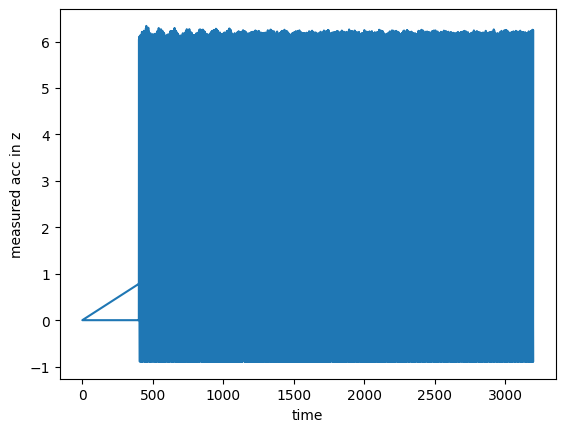

In [57]:
plt.plot(df2['z'],label='original')
plt.xlabel('time')
plt.ylabel('measured acc in z')

0.001 1.111516501741028
0.01 1.4379739655709953


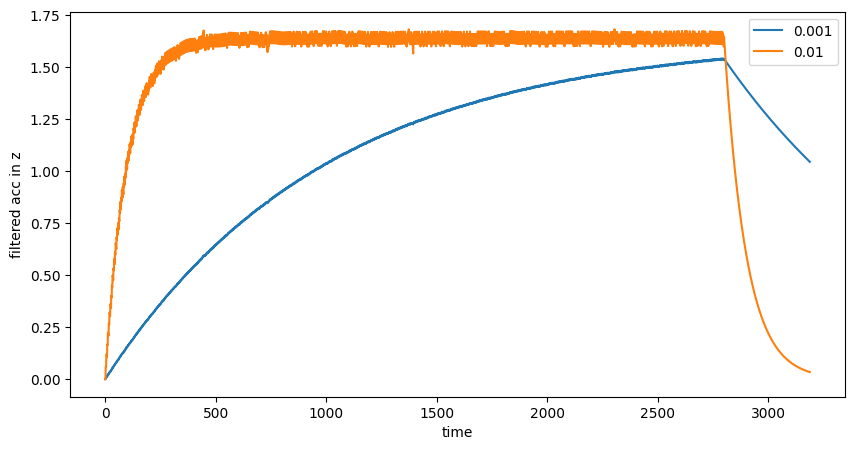

In [58]:
plt.figure(figsize=(10,5))
plt.plot(low_pass_filter(df2['z'],0.001),label='0.001')
plt.plot(low_pass_filter(df2['z'],0.01),label='0.01')
plt.xlabel('time')
plt.ylabel('filtered acc in z')
plt.legend()

In [59]:
df2['acc_x'] = low_pass_filter(df2['x'],0.01)
df2['acc_y'] = low_pass_filter(df2['y'],0.01)
df2['acc_z'] = low_pass_filter(df2['z'],0.01)
df2['acc'] = np.sqrt(df2['acc_x']*df2['acc_x'] + df2['acc_y']*df2['acc_y'] + df2['acc_z']*df2['acc_z'])


0.01 0.03017309877277643
0.01 1.7900468588766167
0.01 1.4379739655709953


In [60]:
dist = 0.0 # meters
ini_vel = 0.0

for i in range(1,len(df2)):
    interval  = (df2.iloc[i]['time'] - df2.iloc[i-1]['time']) / 1e+9
    fin_vel  = ini_vel + (df2.iloc[i]['acc']*interval) #u+at
    dist += (ini_vel*interval) + 0.5*df2.iloc[i]['acc']*interval*interval #ut+0.5*at^2
    ini_vel= fin_vel
print(dist,ini_vel)

5.028296023347265 5.177374884407752


## 3. LPF for calculating Linear acceleration
https://github.com/KalebKE/AccelerationExplorer/wiki/Low-Pass-Filter-Linear-Acceleration

In [ ]:
df = pd.read_csv('/Users/atufasheen/Desktop/projects/meiro_work/EP1_Stationary on mobile phone stand on table, slight tilt-jerk at the end.csv'
                    ,sep=';',names=['time','type','x','y','z','ang_x','ang_y','ang_z'])
df = df[400:(400*8)] # taking, data from 2-10 sec

In [25]:
gx = 0
gy = 0
gz = 0

def grav_x(ax):
    global gx
    alpha = 0.01
    val = alpha*gx+(1-alpha)*ax
    gx = val
    return val

def grav_y(ay):
    global gy
    alpha = 0.01
    val = alpha*gy+(1-alpha)*ay
    gy = val
    return val

def grav_z(az):
    global gz
    alpha = 0.01
    val = alpha*gz+(1-alpha)*az
    gz = val
    return val

In [26]:
df['gx'] = df['x'].apply(lambda x: grav_x(x))
df['gy'] = df['y'].apply(lambda x: grav_y(x))
df['gz'] = df['z'].apply(lambda x: grav_z(x))

In [27]:
df['lin_acc_x'] = df['x'] - df['gx']
df['lin_acc_y'] = df['y'] - df['gy']
df['lin_acc_z'] = df['z'] - df['gz']

<AxesSubplot: >

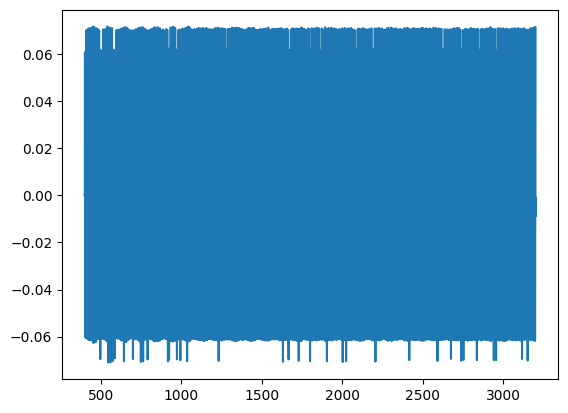

In [31]:
df['lin_acc_z'].plot()

In [34]:
df['acc'] = np.sqrt(df['lin_acc_x']*df['lin_acc_x'] + df['lin_acc_y']*df['lin_acc_y'] + df['lin_acc_z']*df['lin_acc_z'])

In [37]:
dist = 0.0 # meters
ini_vel = 0.0

for i in range(1,len(df)):
    interval  = (df.iloc[i]['time'] - df.iloc[i-1]['time']) / 1e+9
    fin_vel  = ini_vel + (df.iloc[i]['acc']*interval) #u+at
    dist += (ini_vel*interval) + 0.5*df.iloc[i]['acc']*interval*interval #ut+0.5*at^2
    ini_vel= fin_vel

In [38]:
print(dist,ini_vel)

0.21636008334471538 0.2152719809877148
